In [ ]:
# Hi baltha

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [24]:
df =  pd.read_csv('https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/baltha/df_EUR_monthly_capitalization.csv')

In [25]:
df_1= df.drop(df.columns[:4], axis=1)

In [32]:
df_1

,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,2000-09-30 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
0,FLUGHAFEN WIEN,567.85,559.05,576.48,498.86,517.64,554.94,525.07,532.96,561.74,...,2453.36,2388.16,2366.48,2875.89,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21
1,ERSTE GROUP BANK,1803.98,1857.91,1910.40,1827.24,1810.26,1887.98,1894.88,1976.01,2132.84,...,15823.98,13448.16,13356.15,10873.35,10824.56,9715.28,9532.79,10602.50,13099.32,13715.54
2,OMV,2583.84,2113.74,2065.10,2223.10,2305.32,2355.20,1976.43,2004.76,1951.03,...,15799.81,16951.82,19071.10,15313.75,13821.87,13255.37,11981.47,15085.69,16902.76,16800.81
3,VERBUND,1655.07,1781.21,1618.73,1446.45,1554.72,1556.20,1497.30,1409.89,1403.01,...,18088.45,18353.60,16894.99,16612.75,18659.53,16321.45,14584.20,13333.42,15082.96,14289.58
4,WIENERBERGER,1386.43,1283.95,1428.44,1487.43,1567.26,1583.88,1544.56,1482.09,1487.63,...,3511.64,3280.93,3173.55,2466.15,2635.59,2703.34,2324.62,2634.32,2896.84,2690.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,NIBE INDUSTRIER,61.11,64.39,68.47,67.18,65.64,66.33,64.51,65.30,64.48,...,20097.57,17739.52,15508.29,13362.37,17802.84,16809.54,16082.16,14214.49,16381.75,16615.26
504,ELECTROLUX B,7593.79,6702.68,6739.48,6026.53,6006.13,5542.50,5300.71,4415.66,4473.49,...,4617.69,4245.08,4258.84,3692.71,3933.26,3496.16,2878.77,3389.53,3828.45,3714.02
505,ATLAS COPCO A,3539.84,3231.37,3400.32,3273.63,3104.37,2711.52,2936.46,2890.92,2403.54,...,44287.14,38732.62,37523.50,31313.66,38867.54,34336.09,31707.46,35865.30,40666.87,39667.59
506,MODERN TIMES GROUP MTG B,2083.35,2318.42,2166.79,2195.59,1990.56,2195.09,1834.42,1304.32,1189.68,...,1627.46,1177.55,1294.68,883.00,1307.19,1119.39,846.93,951.81,978.44,1087.43


In [43]:
df_1['returns'] =  df_1.iloc[:, 1:].mean(axis=1)

In [48]:
df_1['ann_mean_returns'] = round(df_1['returns']*12,2)

In [66]:
returns = df_1.iloc[:, 1:]

# Calculate the standard deviation of returns for each row
row_std_dev = returns.std(axis=1)

# Number of periods in a year (assuming monthly data, 12 months in a year)
periods_per_year = 12

# Compute the annual volatility for each row
df_1['ann_volatility'] = row_std_dev * np.sqrt(periods_per_year)

In [67]:
df_1

,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,2000-06-30 00:00:00,2000-07-31 00:00:00,2000-08-31 00:00:00,2000-09-30 00:00:00,...,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,returns,Ann_mean_returns,ann_mean_returns,ann_volatility
0,FLUGHAFEN WIEN,567.85,559.05,576.48,498.86,517.64,554.94,525.07,532.96,561.74,...,2809.31,2778.87,2719.75,2739.62,2854.20,2900.21,1766.603986,21199.25,21199.25,18660.567205
1,ERSTE GROUP BANK,1803.98,1857.91,1910.40,1827.24,1810.26,1887.98,1894.88,1976.01,2132.84,...,10824.56,9715.28,9532.79,10602.50,13099.32,13715.54,12440.215688,149282.59,149282.59,47296.592782
2,OMV,2583.84,2113.74,2065.10,2223.10,2305.32,2355.20,1976.43,2004.76,1951.03,...,13821.87,13255.37,11981.47,15085.69,16902.76,16800.81,11879.259420,142551.11,142551.11,45809.046459
3,VERBUND,1655.07,1781.21,1618.73,1446.45,1554.72,1556.20,1497.30,1409.89,1403.01,...,18659.53,16321.45,14584.20,13333.42,15082.96,14289.58,5801.409493,69616.91,69616.91,29081.772034
4,WIENERBERGER,1386.43,1283.95,1428.44,1487.43,1567.26,1583.88,1544.56,1482.09,1487.63,...,2635.59,2703.34,2324.62,2634.32,2896.84,2690.25,2382.716920,28592.60,28592.60,19348.172714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,NIBE INDUSTRIER,61.11,64.39,68.47,67.18,65.64,66.33,64.51,65.30,64.48,...,17802.84,16809.54,16082.16,14214.49,16381.75,16615.26,3518.472246,42221.67,42221.67,27488.423411
504,ELECTROLUX B,7593.79,6702.68,6739.48,6026.53,6006.13,5542.50,5300.71,4415.66,4473.49,...,3933.26,3496.16,2878.77,3389.53,3828.45,3714.02,6617.110072,79405.32,79405.32,27475.984340
505,ATLAS COPCO A,3539.84,3231.37,3400.32,3273.63,3104.37,2711.52,2936.46,2890.92,2403.54,...,38867.54,34336.09,31707.46,35865.30,40666.87,39667.59,18786.278768,225435.35,225435.35,76506.059429
506,MODERN TIMES GROUP MTG B,2083.35,2318.42,2166.79,2195.59,1990.56,2195.09,1834.42,1304.32,1189.68,...,1307.19,1119.39,846.93,951.81,978.44,1087.43,1965.290435,23583.49,23583.49,18861.376932


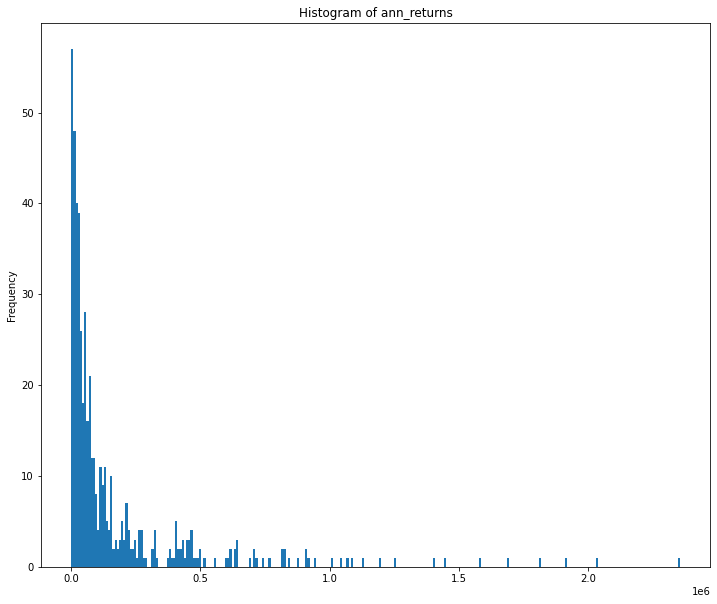

In [58]:
plt.figure(figsize=(12, 10))
plt.hist(df_1['ann_mean_returns'], bins=df_1.shape[1])  # Adjust the number of bins as needed
plt.xlabel('') 
plt.ylabel('Frequency')
plt.title('Histogram of ann_returns')
plt.show()


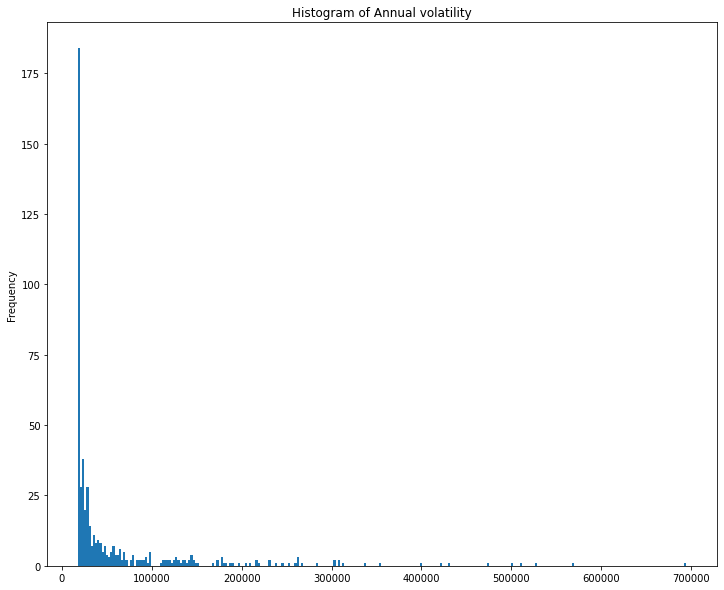

In [68]:
plt.figure(figsize=(12, 10))
plt.hist(df_1['ann_volatility'], bins=df_1.shape[1])  # Adjust the number of bins as needed
plt.xlabel('') 
plt.ylabel('Frequency')
plt.title('Histogram of Annual volatility')
plt.show()